Source: https://www.kaggle.com/argishti/predicting-customer-churn-with-lightgbm/notebook

In [1]:
### This notebook is based on Josh Starmer detaled youtube tutorial on XGBoost
### https://youtu.be/GrJP9FLV3FE
import pandas as pd, numpy as np
import lightgbm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('Telco_customer_churn.csv', sep=',')
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [6]:
# Let's delete data leakage columns and columns with 1 unique catigory
drop_cols = ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason', 'Count', 'Country', 'State', 'Lat Long', 'CustomerID']
df.drop(drop_cols, axis=1, inplace=True)

In [7]:
# We already know that NaNs are not mapped. But we have white spaces in data, so we will replace them with NaNs
# df.loc[df['Total Charges'] == ' ']
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# df.isna().sum()

In [8]:
# Replace ',' with '.' to convert to float
to_be_numeric = ['Latitude', 'Longitude', 'Monthly Charges', 'Total Charges']

for col in to_be_numeric:
    df[col].replace(',', '.', regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col])

In [9]:
# Let's find catigorical columns
cat_columns = [cname for cname in df.columns if df[cname].dtype == "object"]

# We need 'categorical' type for categorical columns for lightgbm
for col in df.columns:
    if col in cat_columns:
        df[col] = df[col].astype('category')

In [10]:
# Splitting the data 
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


roc_auc of base model: 0.7274970396058447

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1048
           1       0.62      0.58      0.60       361

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.80      0.80      0.80      1409



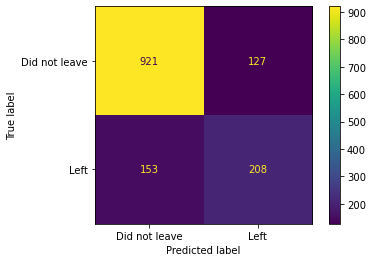

In [11]:
# Base model
lgb_base = lightgbm.LGBMClassifier(random_state=0)
lgb_base.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='auc', verbose=0)

print(f'roc_auc of base model: {roc_auc_score(y_valid, lgb_base.predict(X_valid))}\n')
print(classification_report(y_valid, lgb_base.predict(X_valid)))
plot_confusion_matrix(lgb_base, X_valid, y_valid, values_format='d', display_labels=['Did not leave', 'Left'])

In [12]:
%%time
param_grid = {
              'max_depth': [4, 9, -1],
              'num_leaves': [4, 9],
              'learning_rate': [0.1],
              'scale_pos_weight': [3],
              'n_estimators': [50, 100],
              'reg_lambda': [10, 15],
              'subsample': [0.9],
              'colsample_bytree': [0.5, 0.6]
              }

lgb = lightgbm.LGBMClassifier(random_state=1)

opt_params = GridSearchCV(estimator=lgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3)

opt_params.fit(X_train, y_train, eval_metric='auc', eval_set=(X_valid, y_valid), verbose=0)
params = opt_params.best_params_
print(params)

C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\ismat\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 9, 'reg_lambda': 10, 'scale_pos_weight': 3, 'subsample': 0.9}
Wall time: 56.1 s


roc_auc of final model: 0.7734756613309086

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1048
           1       0.51      0.82      0.63       361

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.82      0.75      0.76      1409



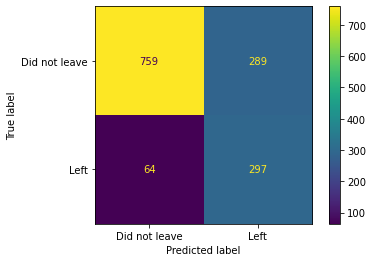

In [13]:
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(X_train, y_train)

print(f'roc_auc of final model: {roc_auc_score(y_valid, lgb.predict(X_valid))}\n')
print(classification_report(y_valid, lgb.predict(X_valid)))
plot_confusion_matrix(lgb, X_valid, y_valid, values_format='d', display_labels=['Did not leave', 'Left'])